In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
#from lmfit import Model, Parameters

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
from joblib import Parallel, delayed
t = pd.date_range(start='2025-1-10', end = '2025-2-15', freq='D')
t_data = np.arange(0, len(t))

def SIDR_model(t, y, beta, f, gamma, tf):
    S, I, D, R, X = y
    N = S + I + D + R
    dSdt = - beta * S * I / N  
    dIdt = beta * S * I / N - (1/gamma) * I*(1-f)  - f * I*tf
    dDdt = f * I*tf
    dRdt = (1/gamma) * I*(1-f) 
    dXdt = beta * S * I / N
    return [dSdt, dIdt, dDdt, dRdt, dXdt]


def fit_SIDR(t, beta,gamma):
    N = 1856000 
    I0 = 3  
    D0 = 0
    R0 = 0
    X0 = 3
    S0 = N - I0 - D0 - R0
    y0 = [S0, I0, D0, R0,  X0]
    f = 0.122969838
    tf = 1/4.27778

  

    sol = solve_ivp(SIDR_model, [t[0], t[-1]], y0, args=(beta, f, gamma, tf), t_eval=t)

    return sol.t, sol.y[0],  sol.y[1], sol.y[2], sol.y[3], sol.y[4]

def process_params(t_data, beta, gamma):
    t_vals, S, I, D, R, X = fit_SIDR(t_data, beta,gamma)

    new_cases = np.diff(X, prepend=0)  
    I_sum = new_cases.sum()  



    if 52.5 <= D[-1] < 53.5:
        return {
            #'omega': omega,
            'gamma': gamma,
            'R_value': beta/(f*tf+1/gamma-f*(1/gamma)),
            'beta': beta,
            'I': new_cases,
            'D': D,
            'D_end': D[-1],
            'I_sum': I_sum,
        }
    else:
        return None



gamma_values = np.arange(1, 21.1, 0.1)
#omega_values = np.arange(1, 21.1, 0.1)
R_values_range = np.arange(0, 11.1, 0.1)
f = 0.126491647  
tf = 1/4.27778

# Parallel processing
results1 = Parallel(n_jobs=50)(
    delayed(process_params)(t_data, R_value * (f*tf+1/gamma-f*(1/gamma)), gamma)
    for gamma in gamma_values
    #for omega in omega_values
    for R_value in R_values_range
)

# Filter out None results
results1 = [result for result in results1 if result is not None]

# Convert to DataFrame
combined1 = pd.DataFrame(results1)
combined1.head(2)

,gamma,R_value,beta,I,D,D_end,I_sum
0,6.2,1.7,0.289778,"[3.0, 0.9234580422394969, 1.0407525732387701, ...","[0.0, 0.09160771843078376, 0.19485119539217083...",52.663013,533.797571
1,7.3,1.8,0.268611,"[3.0, 0.8560697019837171, 0.964965989283435, 1...","[0.0, 0.09161505710134712, 0.19488405205181977...",52.883762,497.091144


In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
from joblib import Parallel, delayed

def SEIDR_model(t, y, beta, omega, gamma, f, tf):
    S, E, I, D, R, X = y
    N = S + E + I + D + R
    dSdt = - beta * S * I / N
    dEdt = beta * S * I / N - (1 / omega) * E
    dIdt = (1 / omega) * E - (1 / gamma) * I*(1-f) - f * I*tf
    dDdt = f * I*tf
    dRdt = (1 / gamma) * I*(1-f)
    dXdt = (1 / omega) * E
    return [dSdt, dEdt, dIdt, dDdt, dRdt, dXdt]

def fit_SEIDR(t, beta, omega, gamma, f, tf):
    N = 1856000
    E0 = 0
    I0 = 3
    D0 = 0
    R0 = 0
    X0 =3
    S0 = N - E0 - I0 - D0 - R0
    y0 = [S0, E0, I0, D0, R0, X0]
    sol = solve_ivp(SEIDR_model, [t[0], t[-1]], y0, args=(beta, omega, gamma, f,tf), t_eval=t)
    return sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5]

def process_params(t_data, beta, omega, gamma):
    t_vals, S, E, I, D, R,X = fit_SEIDR(t_data, beta, omega, gamma, f,tf)


    new_cases = np.diff(X, prepend=0)  
    I_sum = new_cases.sum()
    if 52.5 <= D[-1] < 53.5:

        return {
            'f': f,
            'omega':omega,
            'gamma': gamma,
            'R_value': beta/(f*tf+1/gamma-f*(1/gamma)),
            'I': new_cases,
            'D': D,
            'D_end': D[-1],
            'I_sum': I_sum,
        }
    
    else:
        return None



gamma_values = np.arange(1, 21.1, 0.1)
omega_values = np.arange(1, 21.1, 0.1)
R_values_range = np.arange(0, 11.1, 0.1)
f = 0.126491647 

results2 = Parallel(n_jobs=50)(
    delayed(process_params)(t_data, R_value * (f*tf+1/gamma-f*(1/gamma)), omega, gamma)
    for gamma in gamma_values
    for omega in omega_values
    for R_value in R_values_range
)

# Filter out None results
results2 = [result for result in results2 if result is not None]

# Convert to DataFrame
combined2 = pd.DataFrame(results2)
combined2.head(2)

,f,omega,gamma,R_value,I,D,D_end,I_sum
0,0.126492,1.4,1.0,1.4,"[3.0, 0.8611285597426006, 1.6537395567886657, ...","[0.0, 0.06593749651751964, 0.11969023176194041...",52.604910,1867.688422
1,0.126492,4.7,1.0,2.1,"[3.0, 0.4382468503814998, 0.9423432308939015, ...","[0.0, 0.06214472207926783, 0.10213621073565816...",53.218074,1922.955061


In [4]:
combined1['Group'] = 'Combined1'
combined2['Group'] = 'Combined2'

combined_data = pd.concat([combined1, combined2])

C:\Users\ZERO\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


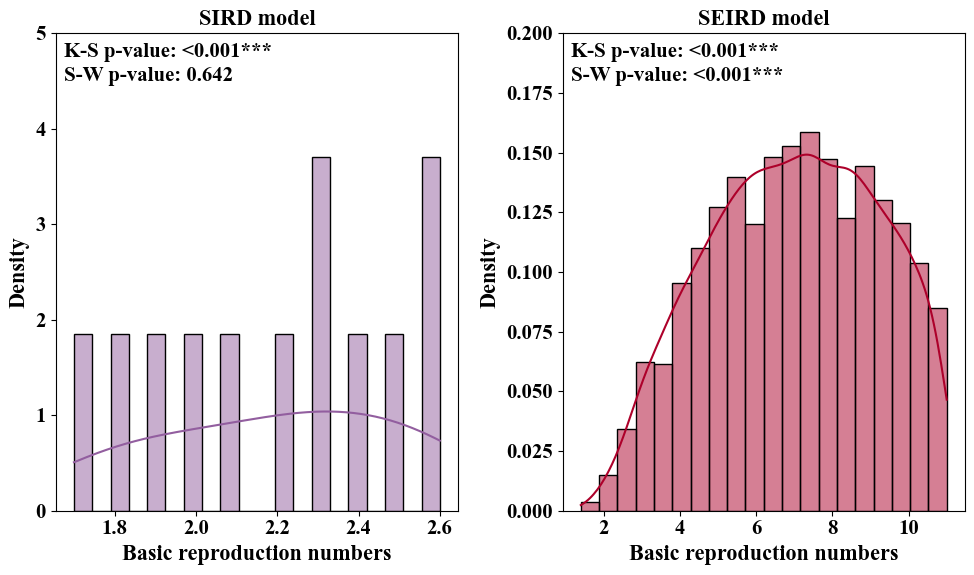

In [5]:
from scipy.stats import kstest, shapiro
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import scipy.stats as stats

plt.rc('font', family='Times New Roman')
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.weight'] = 'bold'
# 绘制直方图和 KDE 图
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# 设置标题（SIRD 和 SEIRD）
titles = ['SIRD model', 'SEIRD model']

# 循环绘制每个子图
for i, (data, title, color) in enumerate(zip([combined1, combined2], titles, ['#925E9FFF', '#AD002AFF'])):#FDAF91FF
    ax = axes[i]
    
    # 绘制直方图和核密度估计图
    sns.histplot(data['R_value'], bins=20, kde=True, color=color,  stat='density', ax=ax, legend=False)
    
    # 计算 K-S 和 S-W 检验的 p 值
    ks_stat, ks_pvalue = kstest(data['R_value'], 'norm')  # K-S 检验
    sw_stat, sw_pvalue = shapiro(data['R_value'])  # S-W 检验
    
    # 在图中添加 K-S 和 S-W 检验的 p 值
    ax.text(0.02, 0.95, f'K-S p-value: {"<0.001***" if ks_pvalue < 0.001 else f"{ks_pvalue:.3f}"}', transform=ax.transAxes)
    ax.text(0.02, 0.90, f'S-W p-value: {"<0.001***" if sw_pvalue < 0.001 else f"{sw_pvalue:.3f}"}', transform=ax.transAxes)
    axes[0].set_ylim(0,5)
    axes[1].set_ylim(0,0.20)
    # 添加标题和标签
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})
    ax.set_xlabel('Basic reproduction numbers', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    ax.set_ylabel('Density', fontdict={'fontsize': 16, 'fontweight': 'bold'})

# 调整布局
plt.tight_layout()

#plt.savefig(f"C:\\Users\\dmxy\\Desktop\\Congo\\R0分布.pdf", dpi=450, bbox_inches='tight') 
plt.show()

C:\Users\ZERO\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


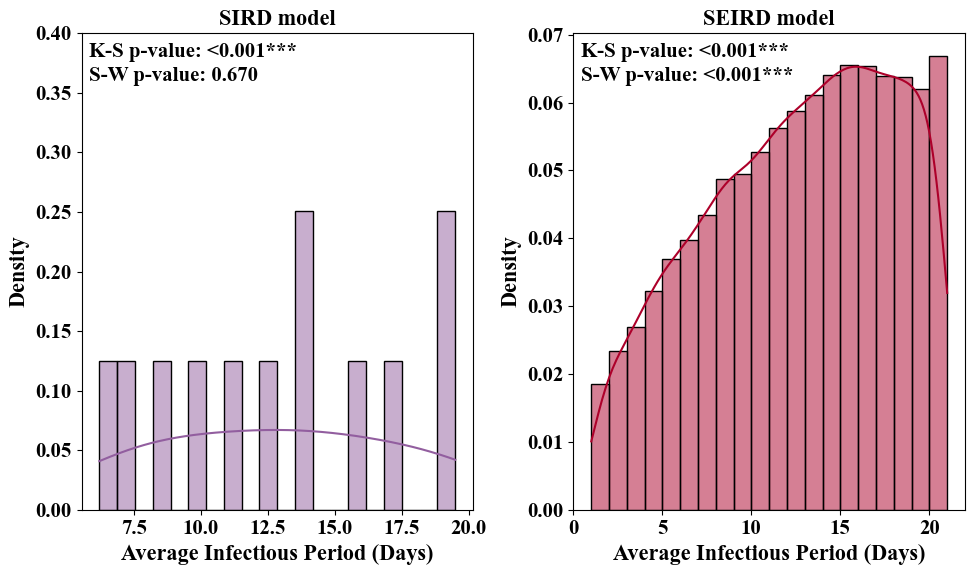

In [6]:
from scipy.stats import kstest, shapiro
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import scipy.stats as stats

plt.rc('font', family='Times New Roman')
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.weight'] = 'bold'
# 绘制直方图和 KDE 图
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# 设置标题（SIRD 和 SEIRD）
titles = ['SIRD model', 'SEIRD model']

# 循环绘制每个子图
for i, (data, title, color) in enumerate(zip([combined1, combined2], titles, ['#925E9FFF', '#AD002AFF'])):
    ax = axes[i]
    
    # 绘制直方图和核密度估计图
    sns.histplot(data['gamma'], bins=20, kde=True, color=color,  stat='density', ax=ax, legend=False)
    
    # 计算 K-S 和 S-W 检验的 p 值
    ks_stat, ks_pvalue = kstest(data['gamma'], 'norm')  # K-S 检验
    sw_stat, sw_pvalue = shapiro(data['gamma'])  # S-W 检验
    
    # 在图中添加 K-S 和 S-W 检验的 p 值
    ax.text(0.02, 0.95, f'K-S p-value: {"<0.001***" if ks_pvalue < 0.001 else f"{ks_pvalue:.3f}"}', transform=ax.transAxes)
    ax.text(0.02, 0.90, f'S-W p-value: {"<0.001***" if sw_pvalue < 0.001 else f"{sw_pvalue:.3f}"}', transform=ax.transAxes)
    axes[0].set_ylim(0,0.4)
    # 添加标题和标签
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})
    ax.set_xlabel('Average Infectious Period (Days)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    ax.set_ylabel('Density', fontdict={'fontsize': 16, 'fontweight': 'bold'})

# 调整布局
plt.tight_layout()

#plt.savefig(f"C:\\Users\\dmxy\\Desktop\\Congo\\传染期分布.pdf", dpi=450, bbox_inches='tight') 
plt.show()

C:\Users\ZERO\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


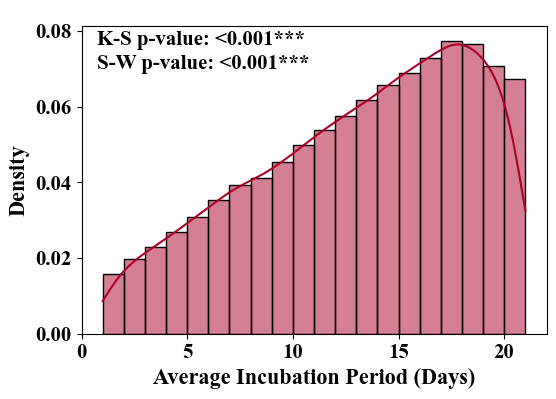

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(combined2['omega'], bins=20, kde=True, color='#AD002AFF',  stat='density')

# 计算 K-S 和 S-W 检验的 p 值
ks_stat, ks_pvalue = kstest(combined2['omega'], 'norm')  # K-S 检验
sw_stat, sw_pvalue = shapiro(combined2['omega'])  # S-W 检验

# 在图中添加 K-S 和 S-W 检验的 p 值
plt.text(-1.25, 0.58, f'K-S p-value: {"<0.001***" if ks_pvalue < 0.001 else f"{ks_pvalue:.3f}"}', transform=ax.transAxes)
plt.text(-1.25, 0.53, f'S-W p-value: {"<0.001***" if sw_pvalue < 0.001 else f"{sw_pvalue:.3f}"}', transform=ax.transAxes)
# 添加标题和标签
#plt.title('Histogram and KDE with K-S and S-W p-values')
plt.xlabel('Average Incubation Period (Days)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Density', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.title
#plt.savefig(f"C:\\Users\\dmxy\\Desktop\\Congo\潜伏期分布.pdf", dpi=450, bbox_inches='tight') 
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ZERO\AppData\Local\Temp\ipykernel_48880\896226393.py:12: SyntaxWarning: invalid escape sequence '\m'
  return f'$\mathit{{p}} = {p:.4f}$'
C:\Users\ZERO\AppData\Local\Temp\ipykernel_48880\896226393.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='R_value', data=combined_data, palette=palette)
C:\Users\ZERO\AppData\Local\Temp\ipykernel_48880\896226393.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['SIRD\nmodel', 'SEIRD\nmodel'])


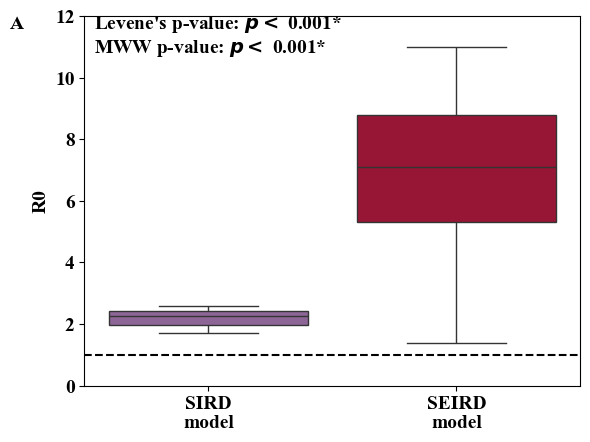

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import scipy.stats as stats

def format_p_value(p):   
    if p < 0.001:
        return r'$\mathit{p} <$ 0.001*'
    else:
        return f'$\mathit{{p}} = {p:.4f}$'
# 设置字体和大小
plt.rc('font', family='Times New Roman')
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.weight': 'bold'})
palette = ['#925E9FFF', '#AD002AFF']
ax = sns.boxplot(x='Group', y='R_value', data=combined_data, palette=palette)

# 进行 t 检验
t_stat, t_p_value = stats.ttest_ind(combined1['R_value'], combined2['R_value'])

# 进行 Mann-Whitney U 检验
u_stat, u_p_value = stats.mannwhitneyu(combined1['R_value'], combined2['R_value'])

# 进行方差齐性检验
levene_stat, levene_p_value = stats.levene(combined1['R_value'], combined2['R_value'])

# 设置 x 轴标签
ax.set_xticklabels(['SIRD\nmodel', 'SEIRD\nmodel'])

# 隐藏 x 轴标签
ax.set_xlabel('')
ax.set_ylabel(r'R0', fontdict={'family': 'Times New Roman', 'fontsize': 14, 'fontweight': 'bold'})


# 添加 p 值文本
text_str = f'Levene\'s p-value: {format_p_value(levene_p_value)}\nMWW p-value: {format_p_value(u_p_value)}'

# 设置字体为新罗马字体
plt.rcParams['font.family'] = 'Times New Roman'
ax.set_ylim(0,12)
# 添加文本到图中
ax.text(0.02, 0.90, text_str, transform=ax.transAxes, fontsize=14)

ax.axhline(y=1, color='black', linestyle='--', label='R0 = 1')
#ax.text(0.3, 0.91 ,text_str, ha='center', va='center', transform=ax.transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.5))
ax.text(-0.15, 1, 'A', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')
#plt.savefig(f"C:\\Users\\dmxy\\Desktop\\Congo\\R0比较.pdf", dpi=450, bbox_inches='tight') 
plt.show()

C:\Users\ZERO\AppData\Local\Temp\ipykernel_48880\2981977594.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='gamma', data=combined_data, palette=palette)
C:\Users\ZERO\AppData\Local\Temp\ipykernel_48880\2981977594.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['SIRD\nmodel', 'SEIRD\nmodel'])


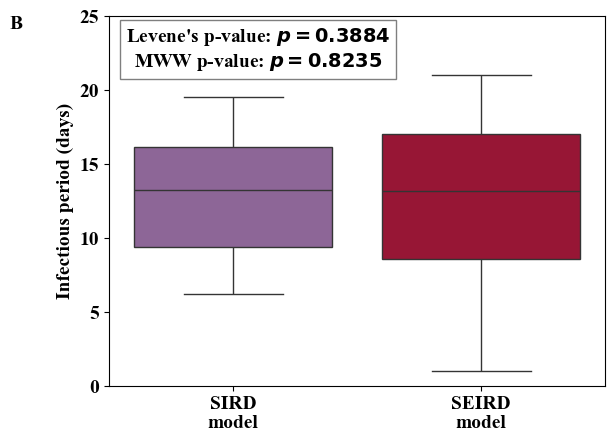

In [9]:
ax = sns.boxplot(x='Group', y='gamma', data=combined_data, palette=palette)

t_stat, t_p_value = stats.ttest_ind(combined1['gamma'], combined2['gamma'])

# 进行 Mann-Whitney U 检验
u_stat, u_p_value = stats.mannwhitneyu(combined1['gamma'], combined2['gamma'])

# 进行方差齐性检验
levene_stat, levene_p_value = stats.levene(combined1['gamma'], combined2['gamma'])
ax.set_xticklabels(['SIRD\nmodel', 'SEIRD\nmodel'])

# 隐藏 x 轴标签
ax.set_xlabel('')
ax.set_ylabel('Infectious period (days)', fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_ylim(0, 25)
text_str = f'Levene\'s p-value: {format_p_value(levene_p_value)}\nMWW p-value: {format_p_value(t_p_value)}'

#ax.axhline(y=1, color='black', linestyle='--', label='R0 = 1')
ax.text(0.3, 0.91 ,text_str, ha='center', va='center', transform=ax.transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.5))
ax.text(-0.2, 1, 'B', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')
#plt.savefig(f"C:\\Users\\dmxy\\Desktop\\Congo\\传染期比较.pdf", dpi=450, bbox_inches='tight') 
plt.show()

C:\Users\ZERO\AppData\Local\Temp\ipykernel_48880\2454206044.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='omega', data=combined_data, palette=palette)
C:\Users\ZERO\AppData\Local\Temp\ipykernel_48880\2454206044.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['SIRD\nmodel', 'SEIRD\nmodel'])


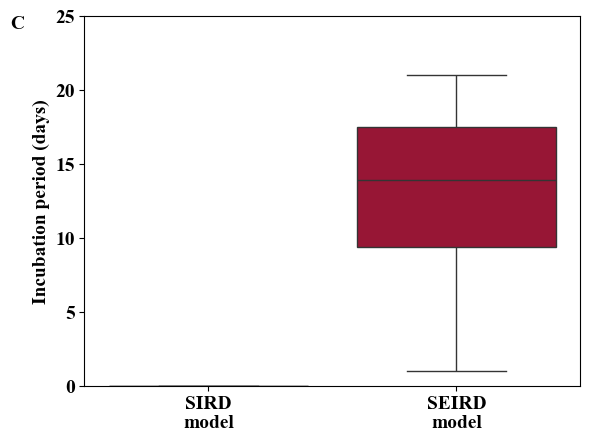

In [10]:
combined_data = combined_data.fillna(0)
ax = sns.boxplot(x='Group', y='omega', data=combined_data, palette=palette)

#t_stat, t_p_value = stats.ttest_ind(combined1['gamma'], combined2['gamma'])

# 进行 Mann-Whitney U 检验
#u_stat, u_p_value = stats.mannwhitneyu(combined1['gamma'], combined2['gamma'])

# 进行方差齐性检验
#levene_stat, levene_p_value = stats.levene(combined1['gamma'], combined2['gamma'])
ax.set_xticklabels(['SIRD\nmodel', 'SEIRD\nmodel'])

# 隐藏 x 轴标签
ax.set_xlabel('')
ax.set_ylabel('Incubation period (days)', fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_ylim(0, 25)
#text_str = f'Levene\'s p-value: {format_p_value(levene_p_value)}\nt-test p-value:: {format_p_value(t_p_value)}'

#ax.axhline(y=1, color='black', linestyle='--', label='R0 = 1')
#ax.text(0.3, 0.91 ,text_str, ha='center', va='center', transform=ax.transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.5))
ax.text(-0.15, 1, 'C', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')
#plt.savefig(f"C:\\Users\\dmxy\\Desktop\\Congo\\潜伏期比较.pdf", dpi=450, bbox_inches='tight') 
plt.show()

In [11]:
R_value = combined1['R_value']

median_R_value = np.mean(R_value)
std_R_value = np.std(R_value)



print("Median of R_value:", median_R_value)
print("IQR of R_value:", std_R_value)

Median of R_value: 2.2000000000000006
IQR of R_value: 0.29154759474226505


In [12]:
R_value = combined1['R_value']

median_R_value = np.median(R_value)

# 计算四分位距（IQR）
Q1 = np.percentile(R_value, 25)
Q3 = np.percentile(R_value, 75)
iqr_R_value = Q3 - Q1

print("Median of R_value:", median_R_value)
print("IQR of R_value:", iqr_R_value)

Median of R_value: 2.25
IQR of R_value: 0.4500000000000002


In [13]:
R_value = combined1['gamma']

median_R_value = np.median(R_value)

# 计算四分位距（IQR）
Q1 = np.percentile(R_value, 25)
Q3 = np.percentile(R_value, 75)
iqr_R_value = Q3 - Q1

print("Median of R_value:", median_R_value)
print("IQR of R_value:", iqr_R_value)

Median of R_value: 13.25000000000001
IQR of R_value: 6.750000000000005


In [14]:
R_value = combined2['R_value']

median_R_value = np.median(R_value)

# 计算四分位距（IQR）
Q1 = np.percentile(R_value, 25)
Q3 = np.percentile(R_value, 75)
iqr_R_value = Q3 - Q1

print("Median of R_value:", median_R_value)
print("IQR of R_value:", iqr_R_value)

Median of R_value: 7.1
IQR of R_value: 3.5


In [15]:
R_value = combined2['gamma']

median_R_value = np.median(R_value)

# 计算四分位距（IQR）
Q1 = np.percentile(R_value, 25)
Q3 = np.percentile(R_value, 75)
iqr_R_value = Q3 - Q1

print("Median of R_value:", median_R_value)
print("IQR of R_value:", iqr_R_value)

Median of R_value: 13.20000000000001
IQR of R_value: 8.400000000000007


In [16]:
R_value = combined2['omega']

median_R_value = np.median(R_value)

# 计算四分位距（IQR）
Q1 = np.percentile(R_value, 25)
Q3 = np.percentile(R_value, 75)
iqr_R_value = Q3 - Q1

print("Median of R_value:", median_R_value)
print("IQR of R_value:", iqr_R_value)

Median of R_value: 13.900000000000011
IQR of R_value: 8.100000000000007


In [17]:
if not all(len(lst) == len(combined1["I"][0]) for lst in combined1["I"]):
    raise ValueError("所有列表必须具有相同的长度")

# 转置数据
transposed1 = list(zip(*combined1["I"]))

# 计算每个位置的最大值、最小值、平均值和标准差
maxI4= [max(values) for values in transposed1]
minI4= [min(values) for values in transposed1]
meanI4 = [np.mean(values) for values in transposed1]
stdI4 = [np.std(values, ddof=1) for values in transposed1]  # 使用样本标准差

# 计算平均值±标准差
mean_plus_stdI4= [mean + std for mean, std in zip(meanI4, stdI4)]
mean_minus_stdI4 = [mean - std for mean, std in zip(meanI4, stdI4)]

# 计算平均值±95%置信区间
ci_lower4 = []
ci_upper4 = []
for values in transposed1:
    n = len(values)
    mean = np.mean(values)
    sem = stats.sem(values)
    lower, upper = stats.t.interval(0.95, df=n-1, loc=mean, scale=sem)
    ci_lower4.append(lower)
    ci_upper4.append(upper)


C:\Users\ZERO\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\ZERO\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


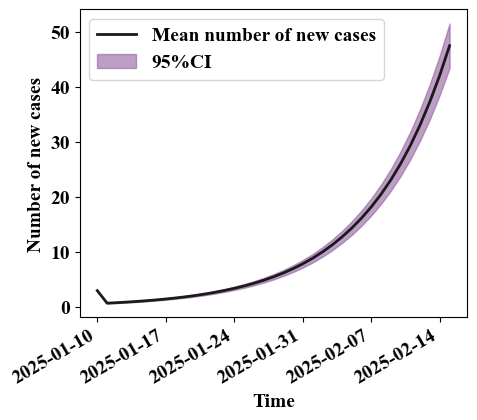

In [18]:
fig, ax = plt.subplots(figsize=(5, 4))

# 绘制平均值曲线
ax.plot(t, meanI4, color='#1B1919FF', label='Mean number of new cases', linewidth =2)

# 填充95%置信区间
ax.fill_between(t, ci_upper4, ci_lower4, color='#925E9FFF', alpha = 0.6,  label='95%CI')

# 设置y轴的限制
#ax.set_ylim(0, 60) 

# 添加图例
ax.legend(loc = 'upper left')

# 设置x轴和y轴标签
ax.set_xlabel('Time', fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_ylabel('Number of new cases', fontdict={'fontsize': 14, 'fontweight': 'bold'})

# 设置x轴的主要定位器和格式化器
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 旋转x轴的刻度标签
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
#plt.savefig(f"C:\\Users\\dmxy\\Desktop\\Congo\\流行曲线1.pdf", dpi=450, bbox_inches='tight') 
plt.show()

In [19]:
ci_upper4 = [0 if pd.isna(x) else x for x in ci_upper4]
ci_lower4 = [0 if pd.isna(x) else x for x in ci_lower4]

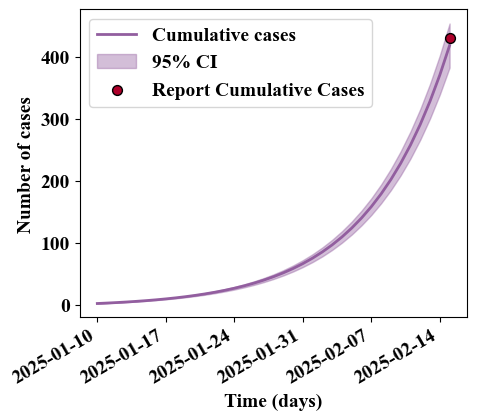

In [21]:
sumcum_meanI = np.cumsum(meanI4)  # 累积病例数
sumcum_ci_upper = np.cumsum(ci_upper4) #积病例数的上置信区间
sumcum_ci_lower = np.cumsum(ci_lower4)  # 累积病例数的下置信区间

# 创建图表
fig, ax = plt.subplots(figsize=(5, 4))

# 绘制累积病例数曲线
ax.plot(t, sumcum_meanI, color='#925E9FFF', label='Cumulative cases', linewidth=2)

# 填充95%置信区间
ax.fill_between(t, sumcum_ci_lower+3, sumcum_ci_upper+3, color='#925E9FFF', alpha=0.4, label='95% CI')
ax.scatter(t[-1], 431, color='#AD002AFF', label='Report Cumulative Cases', s=50, edgecolor='k', zorder=5)
# 设置y轴的限制
#ax.set_ylim(0, 440)
# 添加图例
ax.legend(loc='upper left')

# 设置x轴和y轴标签
ax.set_xlabel('Time (days)', fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_ylabel('Number of cases', fontdict={'fontsize': 14, 'fontweight': 'bold'})

# 设置x轴的主要定位器和格式化器
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 旋转x轴的刻度标签
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

#plt.savefig(f"C:\\Users\\dmxy\\Desktop\\Congo\\累积曲线1.pdf", dpi=450, bbox_inches='tight') 
plt.show()

In [22]:
if not all(len(lst) == len(combined2["I"][0]) for lst in combined2["I"]):
    raise ValueError("所有列表必须具有相同的长度")

# 转置数据
transposed2 = list(zip(*combined2["I"]))

# 计算每个位置的最大值、最小值、平均值和标准差
maxI2= [max(values) for values in transposed2]
minI2= [min(values) for values in transposed2]
meanI2 = [np.mean(values) for values in transposed2]
stdI2 = [np.std(values, ddof=1) for values in transposed2]  # 使用样本标准差

# 计算平均值±标准差
mean_plus_stdI2= [mean + std for mean, std in zip(meanI2, stdI2)]
mean_minus_stdI2 = [mean - std for mean, std in zip(meanI2, stdI2)]

# 计算平均值±95%置信区间
ci_lower2 = []
ci_upper2 = []
for values in transposed2:
    n = len(values)
    mean = np.mean(values)
    sem = stats.sem(values)
    lower, upper = stats.t.interval(0.95, df=n-1, loc=mean, scale=sem)
    ci_lower2.append(lower)
    ci_upper2.append(upper)



In [23]:
ci_upper2 = [0 if pd.isna(x) else x for x in ci_upper2]
ci_lower2 = [0 if pd.isna(x) else x for x in ci_lower2]

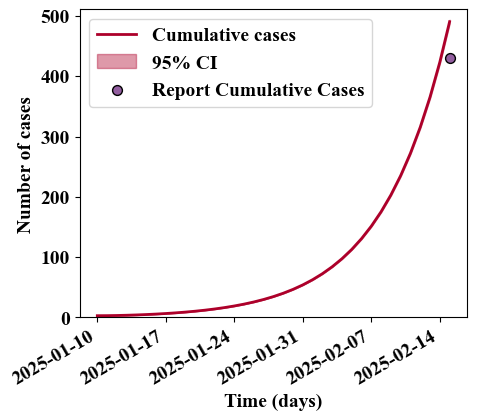

In [24]:
sumcum_meanI = np.cumsum(meanI2)  # 累积病例数
sumcum_ci_upper = np.cumsum(ci_upper2)  # 累积病例数的上置信区间
sumcum_ci_lower = np.cumsum(ci_lower2)  # 累积病例数的下置信区间

# 创建图表
fig, ax = plt.subplots(figsize=(5, 4))

# 绘制累积病例数曲线
ax.plot(t, sumcum_meanI, color='#AD002AFF', label='Cumulative cases', linewidth=2)

# 填充95%置信区间
ax.fill_between(t, sumcum_ci_lower+3, sumcum_ci_upper+3, color='#AD002AFF', alpha=0.4, label='95% CI')
ax.scatter(t[-1], 431, color='#925E9FFF', label='Report Cumulative Cases', s=50, edgecolor='k', zorder=5)
# 设置y轴的限制
ax.set_ylim(0, max(sumcum_meanI.max(), sumcum_ci_upper.max()) + 20)

# 添加图例
ax.legend(loc='upper left')

# 设置x轴和y轴标签
ax.set_xlabel('Time (days)', fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_ylabel('Number of cases', fontdict={'fontsize': 14, 'fontweight': 'bold'})

# 设置x轴的主要定位器和格式化器
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 旋转x轴的刻度标签
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
#plt.savefig(f"C:\\Users\dmxy\\Desktop\\Congo\\累积曲线2.pdf", dpi=450, bbox_inches='tight') 
plt.show()